In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Simulation Parameters
dt = .0001 # time step

#Enviromental Parameters
drag = 10
sigma = 10



class Langevin_Particle: # Create Langevin Particles
    def __init__(self, mass):
        self.x = 0
        self.mass = mass
        self.xtraj = [0]
        self.vx = 0
        self.energy = (1/2)*self.mass*(self.vx**2)
    
    
    def move(self): # Move particles
        self.x += dt*self.vx #Update X positions
        self.xtraj = np.append(self.xtraj, self.x) #Update X trajectory
        self.vx += -dt*(drag/self.mass)*self.vx + dt*(1/self.mass)*np.random.normal(scale= sigma)
        self.energy = (1/2)*self.mass*(self.vx**2)

In [2]:
population = 2000 #number of particle
pop = [Langevin_Particle(mass=1) for i in range(population)]
energies = [(particle.vx**2)*particle.mass/2 for particle in pop]
distance = [np.sqrt(particle.x**2) for particle in pop]
MKenergy = np.mean(energies)
Mdistance = np.mean(distance)
times = np.arange(0, 1, dt)
v = []
X = []
for t in tqdm(times[:len(times)-1]):
    if t in [0.01,0.2,0.4, 0.6, 0.8]:
            X.append([particle.x for particle in pop ])
            
    for particle in pop:
        particle.move()
        if t>0.2:
            v.append(particle.vx)
    energies = [(particle.vx**2)*particle.mass/2 for particle in pop]
    distance = [np.sqrt(particle.x**2) for particle in pop]
    Mdistance = np.append(Mdistance, np.mean(distance) )
    MKenergy = np.append(MKenergy, np.mean(energies) )

100%|██████████| 9999/9999 [04:37<00:00, 36.08it/s]


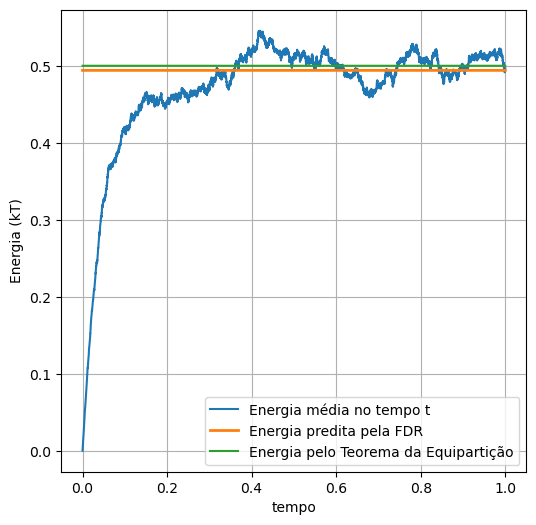

In [3]:
# Flutuação dissipação

kT = 2*np.mean(MKenergy[5000:])
plt.figure(figsize=(6,6))        
plt.plot(times, MKenergy/kT, label='Energia média no tempo t')
plt.plot(times, sigma**2/(4*drag)*dt*np.ones(len(times))/kT, linewidth=2, label='Energia predita pela FDR')
plt.plot(times, (1/2)*np.ones(len(times)), label='Energia pelo Teorema da Equipartição')


plt.xlabel('tempo')
plt.ylabel('Energia (kT)')
plt.grid()
plt.legend()
plt.show()

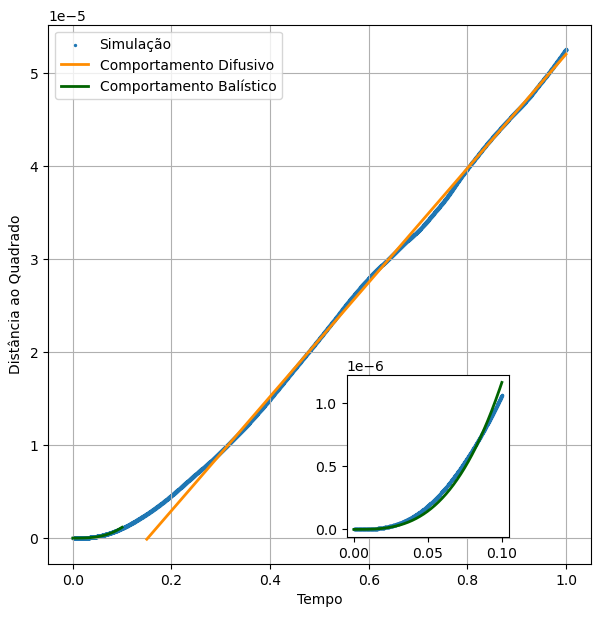

In [4]:
from scipy.optimize import curve_fit

def linear(t,a,b):
    return a*t+b
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(times, Mdistance**2, s=2, label='Simulação')
ax.set_xlabel('Tempo')
ax.set_ylabel('Distância ao Quadrado')

popt, pcov = curve_fit(linear, xdata=times[4000:], ydata=Mdistance[4000:]**2)
ax.plot(times[1500:], linear(times[1500:], *popt), color='darkorange',
        linewidth=2, label='Comportamento Difusivo')


def cubic(x,a):
    return a*x**3

poptc, pcovc = curve_fit(cubic, xdata=times[:1000], ydata=Mdistance[:1000]**2)
ax.plot(times[:1000], cubic(times[:1000], *poptc),
        color='DarkGreen', linewidth=2, label='Comportamento Balístico')

axins = ax.inset_axes([0.55, 0.05, 0.3, 0.3])
axins.plot(times[:1000], cubic(times[:1000], *poptc),
        color='DarkGreen', linewidth=2, label='Comportamento Balístico')
axins.scatter(times[:1000],Mdistance[:1000]**2, s=2 )

ax.grid()
ax.legend()

In [5]:
bins = np.linspace(-0.1, 0.1, 250)
Gibbs, edges = np.histogram(v, bins=bins, density=True)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
m = 1


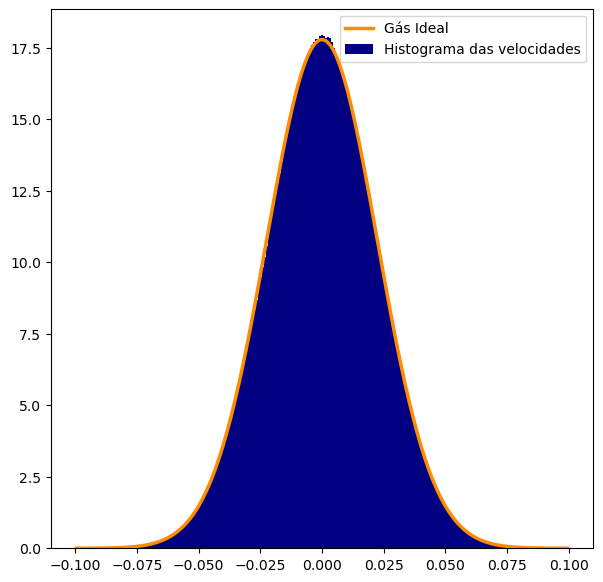

In [6]:
def free_gas(v, m, T, Z):
    return np.exp(-np.abs(m)*v**2/(2*np.abs(T)))/Z

popt, pcov = curve_fit(free_gas, xdata=binscenters, ydata=Gibbs)


plt.figure(figsize=(7,7))
plt.bar(binscenters, Gibbs, width=bins[1] - bins[0], color='navy', label='Histograma das velocidades')
plt.plot(binscenters, free_gas(binscenters, *popt), color='darkorange', linewidth=2.5, label='Gás Ideal')
plt.legend()

(0.0, 900.0)

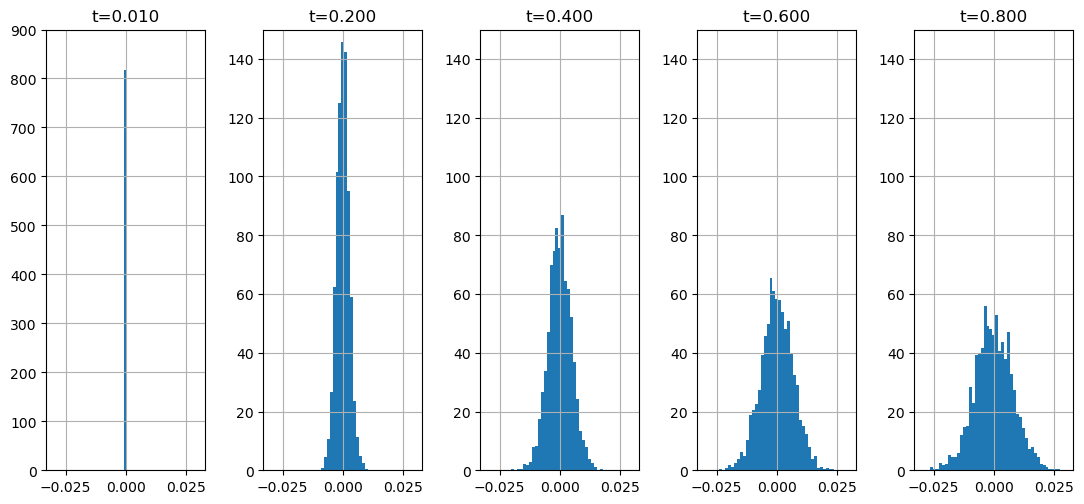

In [7]:
bins = np.linspace(-0.03, 0.03, 50)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
xt =[]
for i in range(5):
    xtdata, edges = np.histogram(X[i], bins=bins, density=True)
    xt.append(xtdata)

fig, ax = plt.subplots(1,5,figsize=(11,5))
fig.tight_layout()
titles = [0.01,0.2,0.4, 0.6, 0.8]
for i in range(5):
    ax[i].bar(binscenters, xt[i], width=bins[1] - bins[0])
    ax[i].set_title('t=%5.3f' %titles[i])
    ax[i].grid()
    ax[i].set_ylim(0,150)


ax[0].set_ylim(0,900)

In [8]:
#Corrigido
#Calculo da Constante de Difusão x sigma
def Kubo(t,D):
    return D*t

sigmalist = [n/2 for n in range(1,21)] 

Dlist =[]

population = 100 #number of particles

critical_time = 1/drag

critical_step = int(critical_time/dt)
a = 10
b = 20
times = [a*critical_step*dt + n*dt for n in range(b*critical_step)]


        
for S in tqdm(sigmalist):
    sigma = S
    Dpop = [Langevin_Particle(mass=1) for i in range(population)]
    # Termalização
    for step in range(a*critical_step): 
        for particle in Dpop:
            particle.move()
    
    Mdistance2 = []
    for step in range(b*critical_step):
        for particle in Dpop:
            particle.move()
            
        distance2 = [particle.x**2 for particle in Dpop]
        Mdistance2 = np.append(Mdistance2, np.mean(distance2) )
    #<x²> = Dt+erro
    poptD, _ = curve_fit(Kubo, xdata=times,
                         ydata=Mdistance2) 
    Dlist.append(poptD)
    

100%|██████████| 20/20 [20:28<00:00, 61.41s/it]


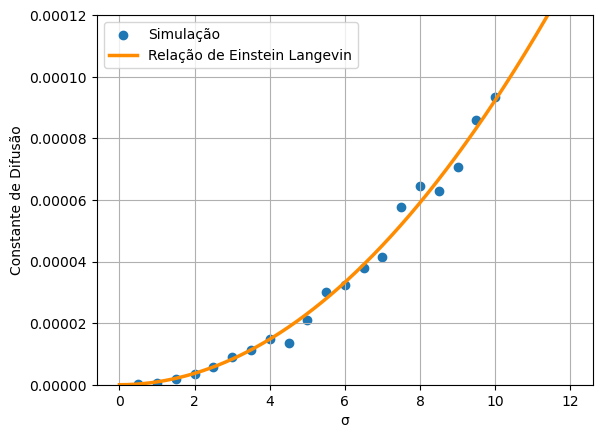

In [9]:
def quad(x,a):
    return a*x**2

x = np.linspace(0,12, 1200)
xdata = np.array(sigmalist)
ydata=np.array([Dlist[n][0] for n in range(len(Dlist))])

poptS,pcovS = curve_fit(quad, xdata, ydata) 
plt.scatter(np.array(sigmalist),Dlist, label='Simulação')
plt.plot(x, quad(x, *poptS), color='darkorange', linewidth=2.5, 
         label='Relação de Einstein Langevin')
plt.ylim(0,0.00012)
plt.xlabel('\u03C3')
plt.ylabel('Constante de Difusão')
plt.grid()
plt.legend()